In [1]:
import numpy as np
import numba as nb
from numba import njit, prange
from tqdm.notebook import tqdm, trange
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:
plt.style.use('bmh')
# cmap=mpl.cm.jet
# cmap.set_under(color='black')
font = {'size'   : 12}
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [3]:
@njit
def nb_seed(seed):
    np.random.seed(seed)

In [4]:
nb_seed(123456)

In [5]:
@njit
def dynamic(α:float, s:int, z:int, r:int, τ:float):
    c = s*z/(s+z+r)
    dτ = np.random.exponential(1/((1+α)*c))
    if np.random.uniform(0, 1) < α/(α+1):  # kill
        return s, z-1, r+1, dτ+τ
    else:  # bite
        return s-1, z+1, r, dτ+τ


In [6]:
@njit
def run_dense(s0:int, z0:int, r0:int, α:float):
    states = np.empty((s0*2, 4), dtype=np.float64)
    states[0] = s0, z0, r0, 0  # S,Z,R,τ
    i = 0
    while states[i, 0] != 0 and states[i, 1] != 0:
        s, z, r, τ = states[i]
        i += 1
        states[i] = dynamic(α, s, z, r, τ)
    return states[:i+1]


In [7]:
def plt_dense_event(states:np.ndarray):
    plt.axes(xlabel='τ',ylabel='N')
    plt.plot(states[:,3],states[:,0],label='S')
    plt.plot(states[:,3],states[:,1],label='Z')
    plt.plot(states[:,3],states[:,2],label='R')
    plt.legend()
    plt.draw()

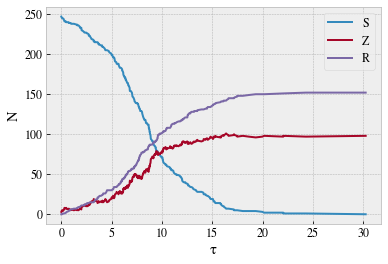

In [8]:
res=run_dense(247,3,0,0.6)
plt_dense_event(res)

In [9]:
@njit(parallel=True)
def alpha_scan(alpha_list: np.ndarray, N_trail: int, S0: int, Z0: int):
    N_alpha = alpha_list.shape[0]
    # counter for # of extinction of zombies in N trails
    N_ext = np.zeros(N_alpha)
    for i in prange(N_alpha):
        α = alpha_list[i]
        for _ in range(N_trail):
            Z_fin = run_dense(S0, Z0, 0, α)[-1, 1]
            if Z_fin == 0:
                N_ext[i] += 1
    return N_ext/N_trail


In [10]:
alpha_list=np.linspace(0,1)
P_ext=alpha_scan(alpha_list,1000,9999,1)

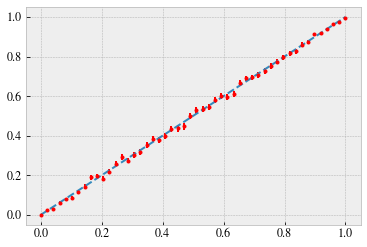

In [11]:
plt.plot((0, 1), (0, 1), '--')
err_bar = np.sqrt(P_ext*(1-P_ext)/1000)
plt.errorbar(alpha_list, P_ext, yerr=err_bar, fmt='.', color='red')
plt.draw()


In [12]:
@njit
def delta_t(adj_SZ:int,α:float):
    """
    adj_SZ: # of edges from vertices of type S to vertices of type Z (or vice versa)
    """
    return np.random.exponential(1/((1+α)*adj_SZ))

@njit
def fire_edge():
    return np.random.choice

In [13]:
@njit
def f():
    return np.random.choice(a=[1,2,3,4,5],p=[0.3,0.3,0.3,0.1,0])

In [14]:
@njit
def weighted_sample(p:np.ndarray):
    cumulative_distribution = np.cumsum(p)
    cumulative_distribution /= cumulative_distribution[-1]
    return np.searchsorted(cumulative_distribution, np.random.rand(1), side="right")[0]

In [15]:
@njit
def nb_warpper(x,y):
    return np.sum(x==y)

In [16]:
@njit
def point_onehot_conv2d(A:np.ndarray,k:np.ndarray,v1:int=0,v2:int=1):
    """
    modified 2d conv on for one-hot vectors
    only odd dimensions allowed for k
    """
    X_ker,Y_ker=k.shape
    bias=(np.array((X_ker,Y_ker),dtype=np.int32)-1)>>1 # Get padding sizes (X,Y)

    A_aug=np.zeros((A.shape[0]+k.shape[0]-1,A.shape[1]+k.shape[1]-1),dtype=np.uint8)
    A_aug[bias[0]:-bias[0],bias[1]:-bias[1]]=(A==v2)
    res=np.empty_like(A,dtype=np.float32)
    for i in prange(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j]==v1:
                res[i,j]=np.sum(k*A_aug[i:i+X_ker,j:j+Y_ker])
            else:
                res[i,j]=0
    return res


In [17]:
defs = {'S': 0, 'Z': 1, 'R': 2}


In [18]:
@njit
def get_target_2_coord(state:np.ndarray,target_1:tuple,k:np.ndarray,target_2_serial:int,v2:int):
    X_bias,Y_bias=(np.array(k.shape,dtype=np.int32)-1)>>1
    x,y=-1,-1
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i,j]!=1:
                continue
            x,y=i-X_bias+target_1[0],j-Y_bias+target_1[1]
            if -1<x<state.shape[0] and -1<y<state.shape[1] and state[x,y]==v2:
                if target_2_serial!=0:
                    target_2_serial-=1
                else:
                    return x,y
    print(target_2_serial)
    return x,y

In [19]:
@njit
def advance_state(state: np.ndarray, k: np.ndarray, α: float):
    S = np.sum(state == 0)
    Z = np.sum(state == 1)
    #    R = np.sum(state == 3)
    v1v2 = (0, 1) if S < Z else (1, 0) # Scan for S around Z or Z around S, whichever is faster.
    SZ = point_onehot_conv2d(state, k, v1=v1v2[0], v2=v1v2[1])
    sum_SZ=np.sum(SZ)
    if sum_SZ==0: # if there is no connection
        return -1,-1,-1
    dτ = delta_t(sum_SZ, α) # Time change
    choices_idx = np.where(SZ.flatten() != 0)[0] # Get probability weights for select the first target (A)
    target_1=choices_idx[weighted_sample(SZ.flatten()[choices_idx])] # 
    Y_tar_1=target_1%state.shape[0]
    X_tar_1=int((target_1-Y_tar_1)/state.shape[0]) # Abs coord for target 1. 
    target_2_serial=np.random.randint(0,SZ[X_tar_1,Y_tar_1]) # The Nth B around A.
    X_tar_2,Y_tar_2=get_target_2_coord(state,(X_tar_1,Y_tar_1),k,target_2_serial,v1v2[1])
    if v1v2[0]==0: #if target 1 is S
        s=(X_tar_1,Y_tar_1)
        z=(X_tar_2,Y_tar_2)
    else:
        z=(X_tar_1,Y_tar_1)
        s=(X_tar_2,Y_tar_2)
    if np.random.uniform(0,1)<α/(1+α): # kill 
        state[z[0],z[1]]=2
        Z-=1
    else: # bite
        state[s[0],s[1]]=1
        S-=1
        Z+=1
    return dτ,S,Z

In [20]:
nb_seed(14)
7

7

In [21]:
state=np.zeros((200,200),dtype=np.uint8)
state[100,100]=1
k=np.array([[0,1,0],[1,0,1],[0,1,0]],dtype=np.uint8)
l=np.prod(state.shape)*2
Sl=np.empty(l,dtype=np.int32)
Zl=np.empty(l,dtype=np.int32)
dtl=np.empty(l,dtype=np.float32)
for i in trange(l):
    dtl[i],Sl[i],Zl[i]=advance_state(state,k,0.43734613)
    if Sl[i]<=0 or Zl[i]<=0:
        break
        

  0%|          | 0/80000 [00:00<?, ?it/s]

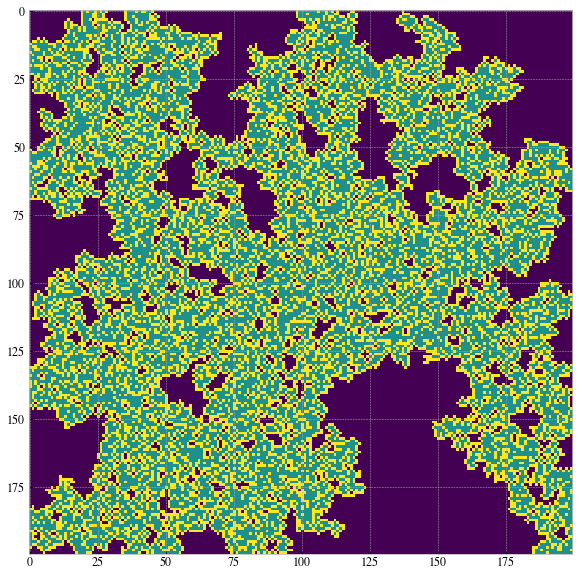

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(state,interpolation='none')
plt.savefig('Z:/200x200.svg')